# QR Heston SPX and VIX smiles from simulation

We use the QRH scheme from `QRH SSR.pdf` to generate SPX and VIX smiles.


In [1]:
# The required packages
library(gsl)
library(MittagLeffleR)
library(statmod)
library(stinepack)
library(repr)


In [2]:
source("gamma_kernel.R")
source("qrh_gamma_y_from_xi.R")
source("qrh_simulation.R")
source("black_scholes.R")
source("plot_ivols_mc.R")


# Gamma kernel

The gamma kernel is given by $$ \kappa(\tau)= \frac{\nu}{\Gamma(\alpha)}\, \tau^{\alpha-1}\,e^{-\lambda \tau}, $$

with $\alpha = H + \tfrac12$.


In [3]:
params0 <- list(al = 0.568, lam = 9.68, nu = 0.572, c = 8.1e-3)


# Kernel convergence condition


We check the necessary condition $$ \int_0^\infty \kappa(s)^2 \, ds = \frac{\nu^2}{\Gamma(\alpha)^2} \frac{\Gamma(2 H)}{(2\lambda)^{2H}} < 1 $$


In [4]:
converge.test <- function(params) {
  al <- params$al
  H <- al - 1 / 2
  lam <- params$lam
  nu <- params$nu
  return(((nu / gamma(al))^2 * gamma(2 * H)) / (2 * lam)^(2 * H))
}


In [5]:
converge.test(params0)


[1] 0.6137021

In [6]:
converge_test <- function(params, opt = "closed-form") {
  al <- params$al
  H <- al - 1 / 2
  lam <- params$lam
  nu <- params$nu

  if (opt == "closed-form") {
    integral <- (nu / gamma(al))^2 * gamma(2 * H) / (2 * lam)^(2 * H)
  } else if (opt == "quad") {
    kernel <- function(x) {
      (nu / gamma(al)) * x^(al - 1) * exp(-lam * x)
    }
    integral <- integrate(function(x) kernel(x)^2, 0, Inf)$value
  } else {
    stop("Check value for opt.")
  }
  stopifnot(integral < 1)
  return(integral)
}

print(converge_test(params0, opt = "closed-form"))
print(converge_test(params0, opt = "quad"))


[1] 0.6137021
[1] 0.6137021


In [7]:
K00(params0)(10**6)


[1] 0.6137021

# Initial forward variance curve $\xi_t(u)$


In [8]:
load(file = "xi_20230215.rData")


In [9]:
xi <- xiCurveObj$getForwardVarCurve()


In [10]:
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 150)


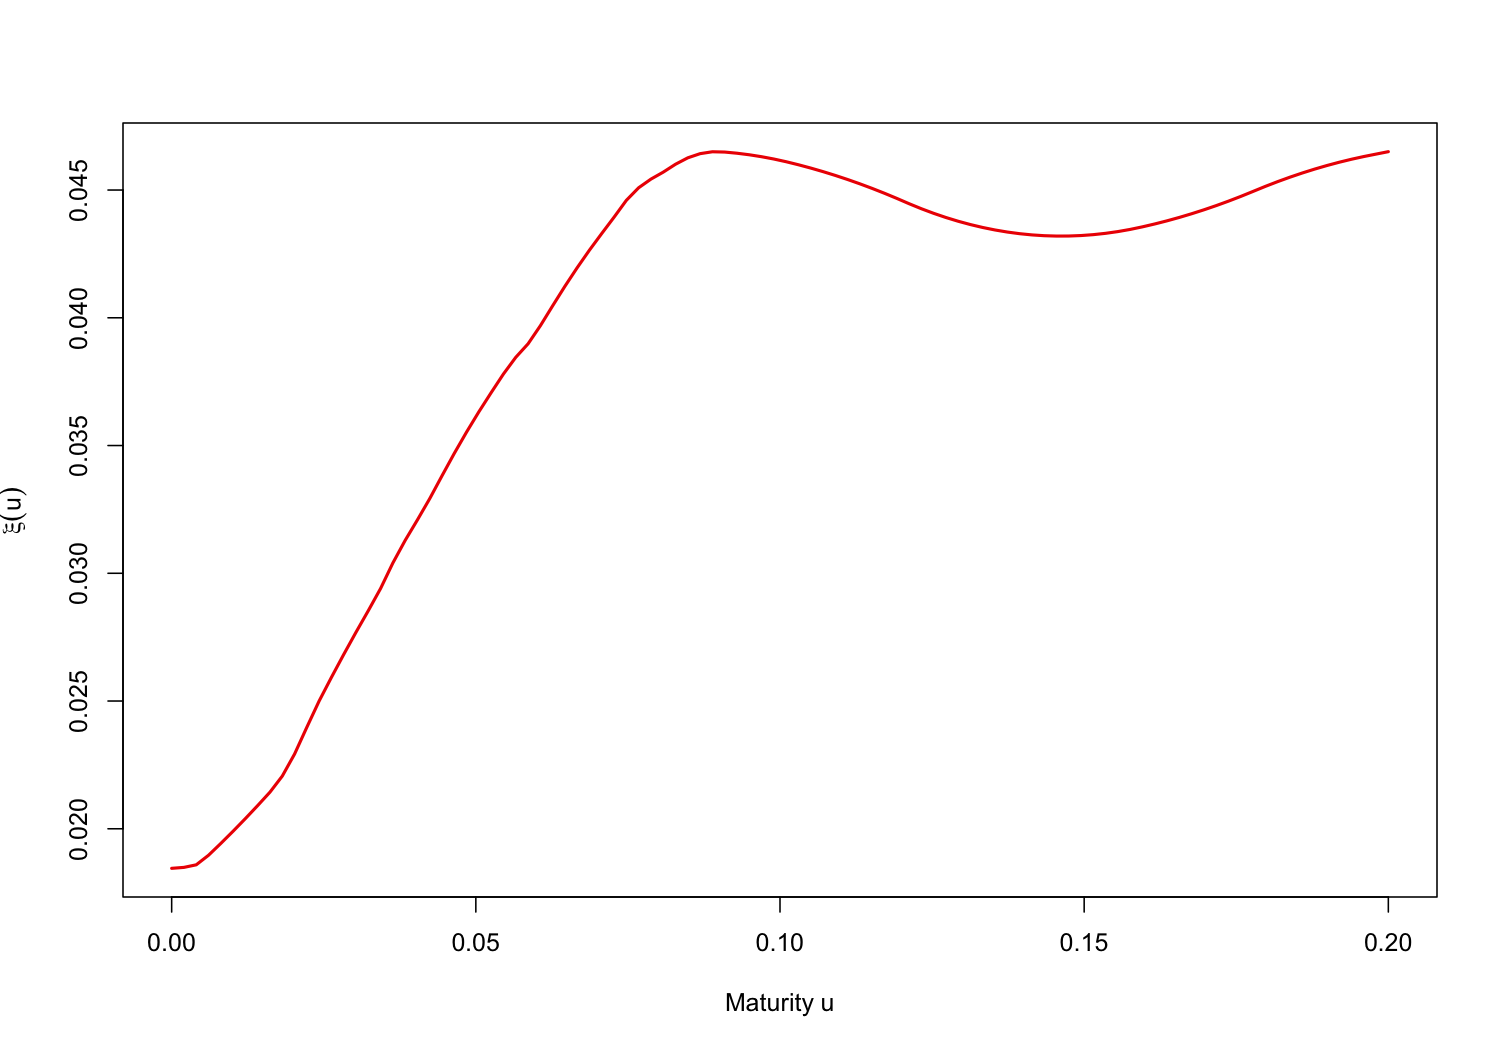

In [11]:
curve(xi,
  from = 0, to = .2, col = "red2", n = 100, lwd = 2,
  xlab = "Maturity u", ylab = expression(xi(u))
)


# $y_t(u)$ from $\xi_t(u)$

$$ y_t(u)^2= \xi_t(u) - c - \int_t^u\,\xi_t(s)\,\kappa (u-s)^2\,ds. $$

Integration is performed using Gauss-Jacobi quadrature.


In [12]:
ey <- yFromXi(params0, xi)


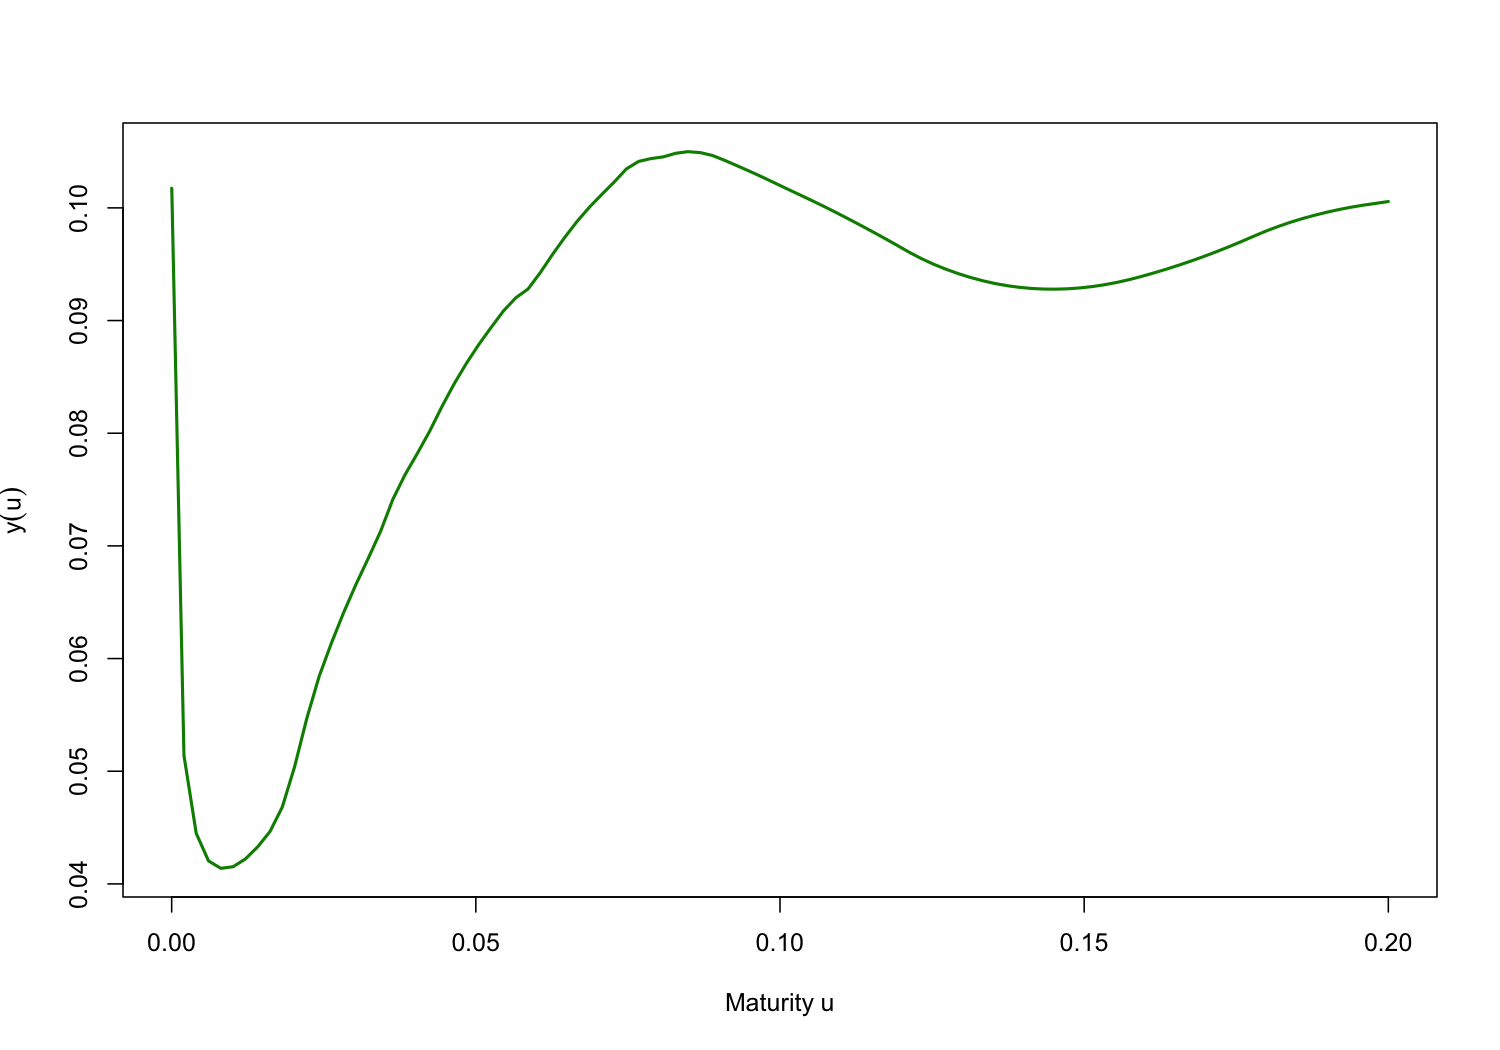

In [13]:
curve(ey,
  from = 0, to = .2, n = 100, col = "green4", lwd = 2,
  xlab = "Maturity u", ylab = expression(y(u))
)


# Load SPX and VIX implied volatility data


In [14]:
load("spx_vix_vols_20230215.rData")


# Choose expiries


In [15]:
(spxExpiries <- c(7, 14, 20, 28) / 365)


[1] 0.01917808 0.03835616 0.05479452 0.07671233

In this particular case, we choose identical SPX and VIX expiries.


In [16]:
(vixExpiries <- spxExpiries)


[1] 0.01917808 0.03835616 0.05479452 0.07671233

# Run simulation


In [17]:
paths <- 1e5
steps <- 100


Change cell type from `RawNBConvert` to `Code` to run with more paths and steps.


The list `spx.all` has all variables of interest for each expiry.


In [18]:
system.time(
  qrh.all <- QRH.sim(params0, xi)(
    paths, steps, nvix = 10, expiries = spxExpiries, output = "all"
  )
)


   user  system elapsed 
 15.165   3.534  19.162 

In [19]:
n.all <- length(qrh.all)


# Extract log-SPX values from list `spx.all`


In [20]:
qrh.spx <- matrix(nrow = n.all, ncol = paths)
for (j in 1:n.all) {
  qrh.spx[j, ] <- qrh.all[[j]]$X
}


In [24]:
options(repr.plot.width = 13, repr.plot.height = 8, repr.plot.res = 150)


In [25]:
spxVolDataExtract <- spxIvols20230215[round(spxIvols20230215$Texp, 3) %in% round(spxExpiries, 3), ]


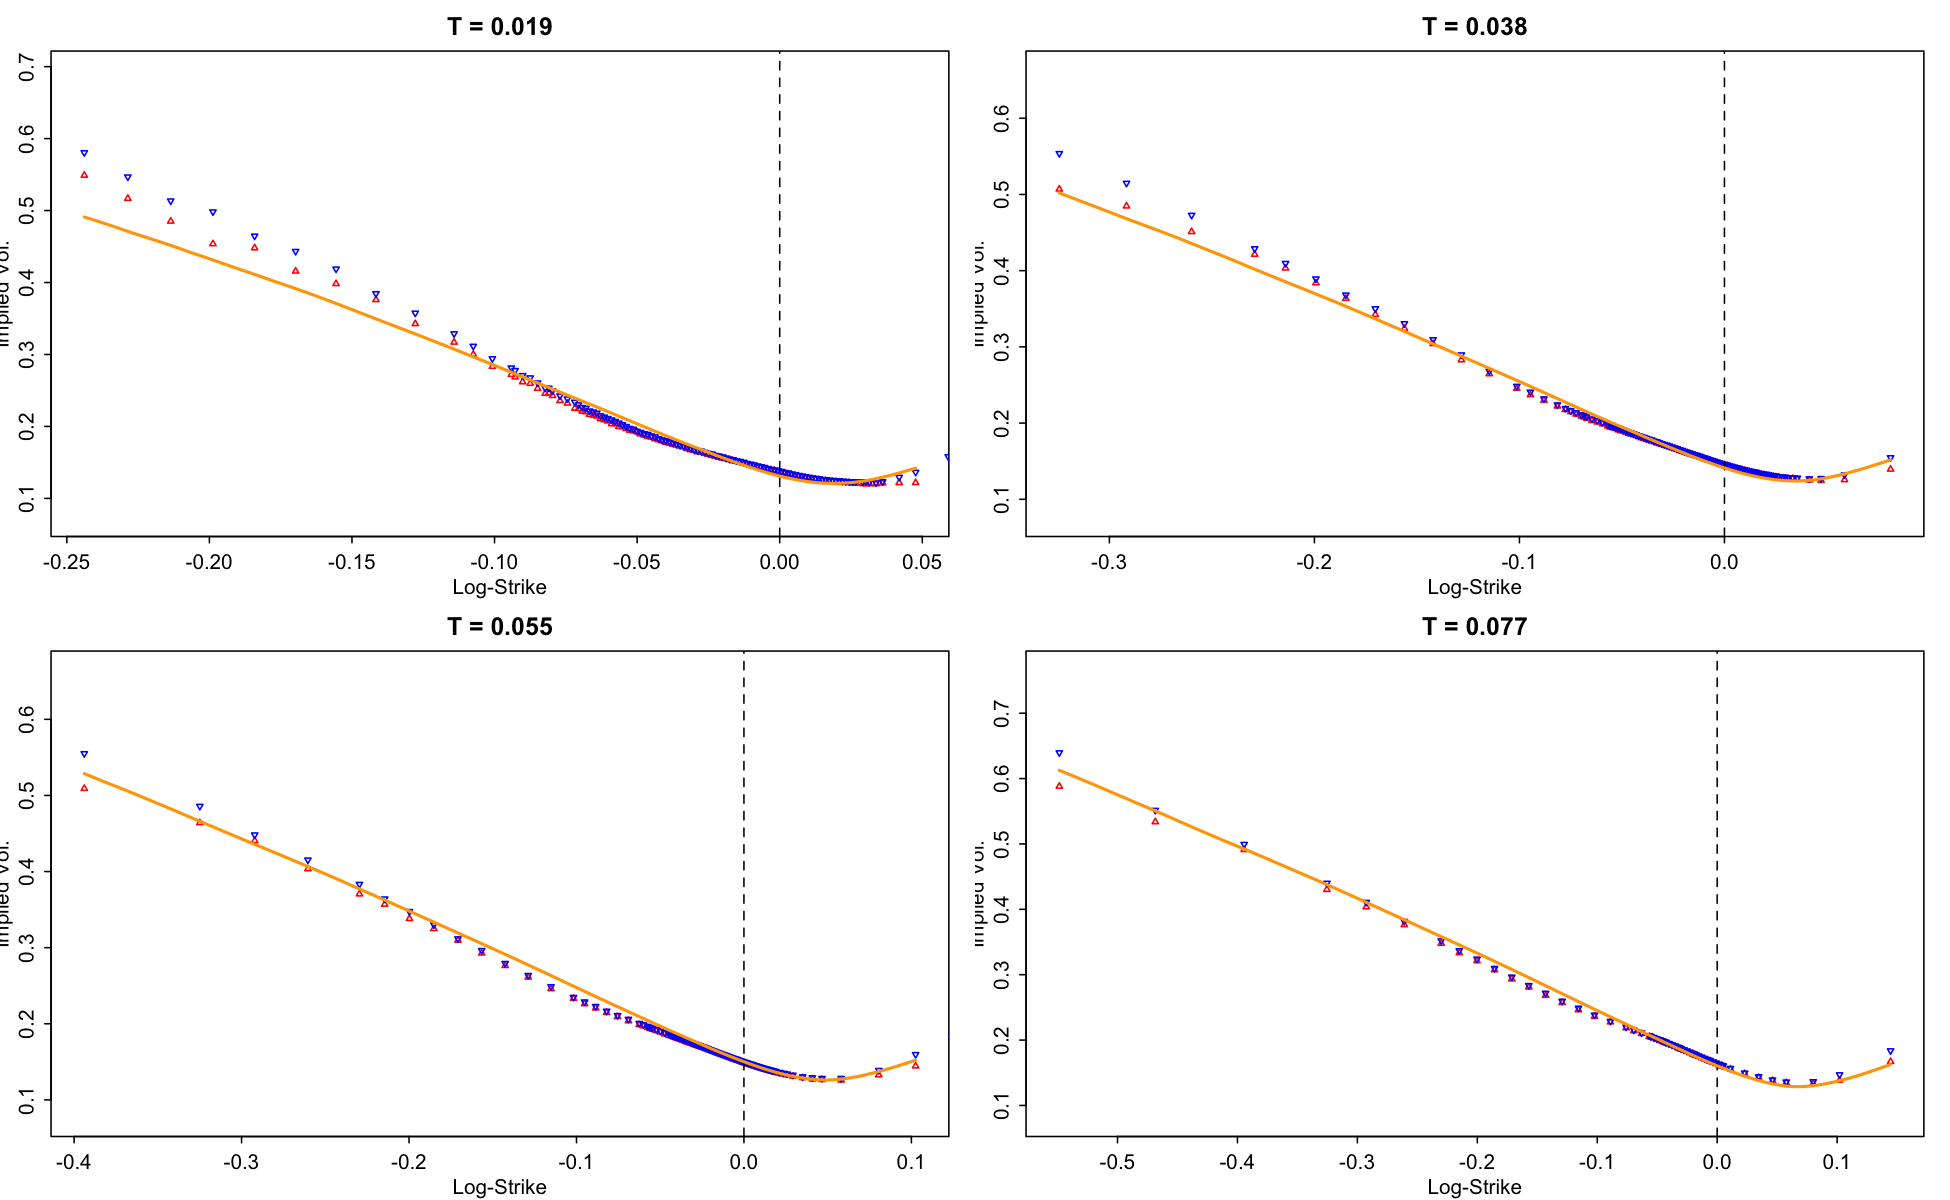

In [26]:
plot.spx <- plotIvolsMC(spxVolDataExtract, mcMatrix = exp(qrh.spx), colnum = 2)


# VIX smiles


# Extract VIX values from list `spx.all`


In [27]:
qrh.vix <- matrix(nrow = n.all, ncol = paths)
for (j in 1:n.all) {
  qrh.vix[j, ] <- qrh.all[[j]]$vix
}


In [28]:
vixVolDataExtract <- vixIvols20230215[vixIvols20230215$Texp < .09, ]


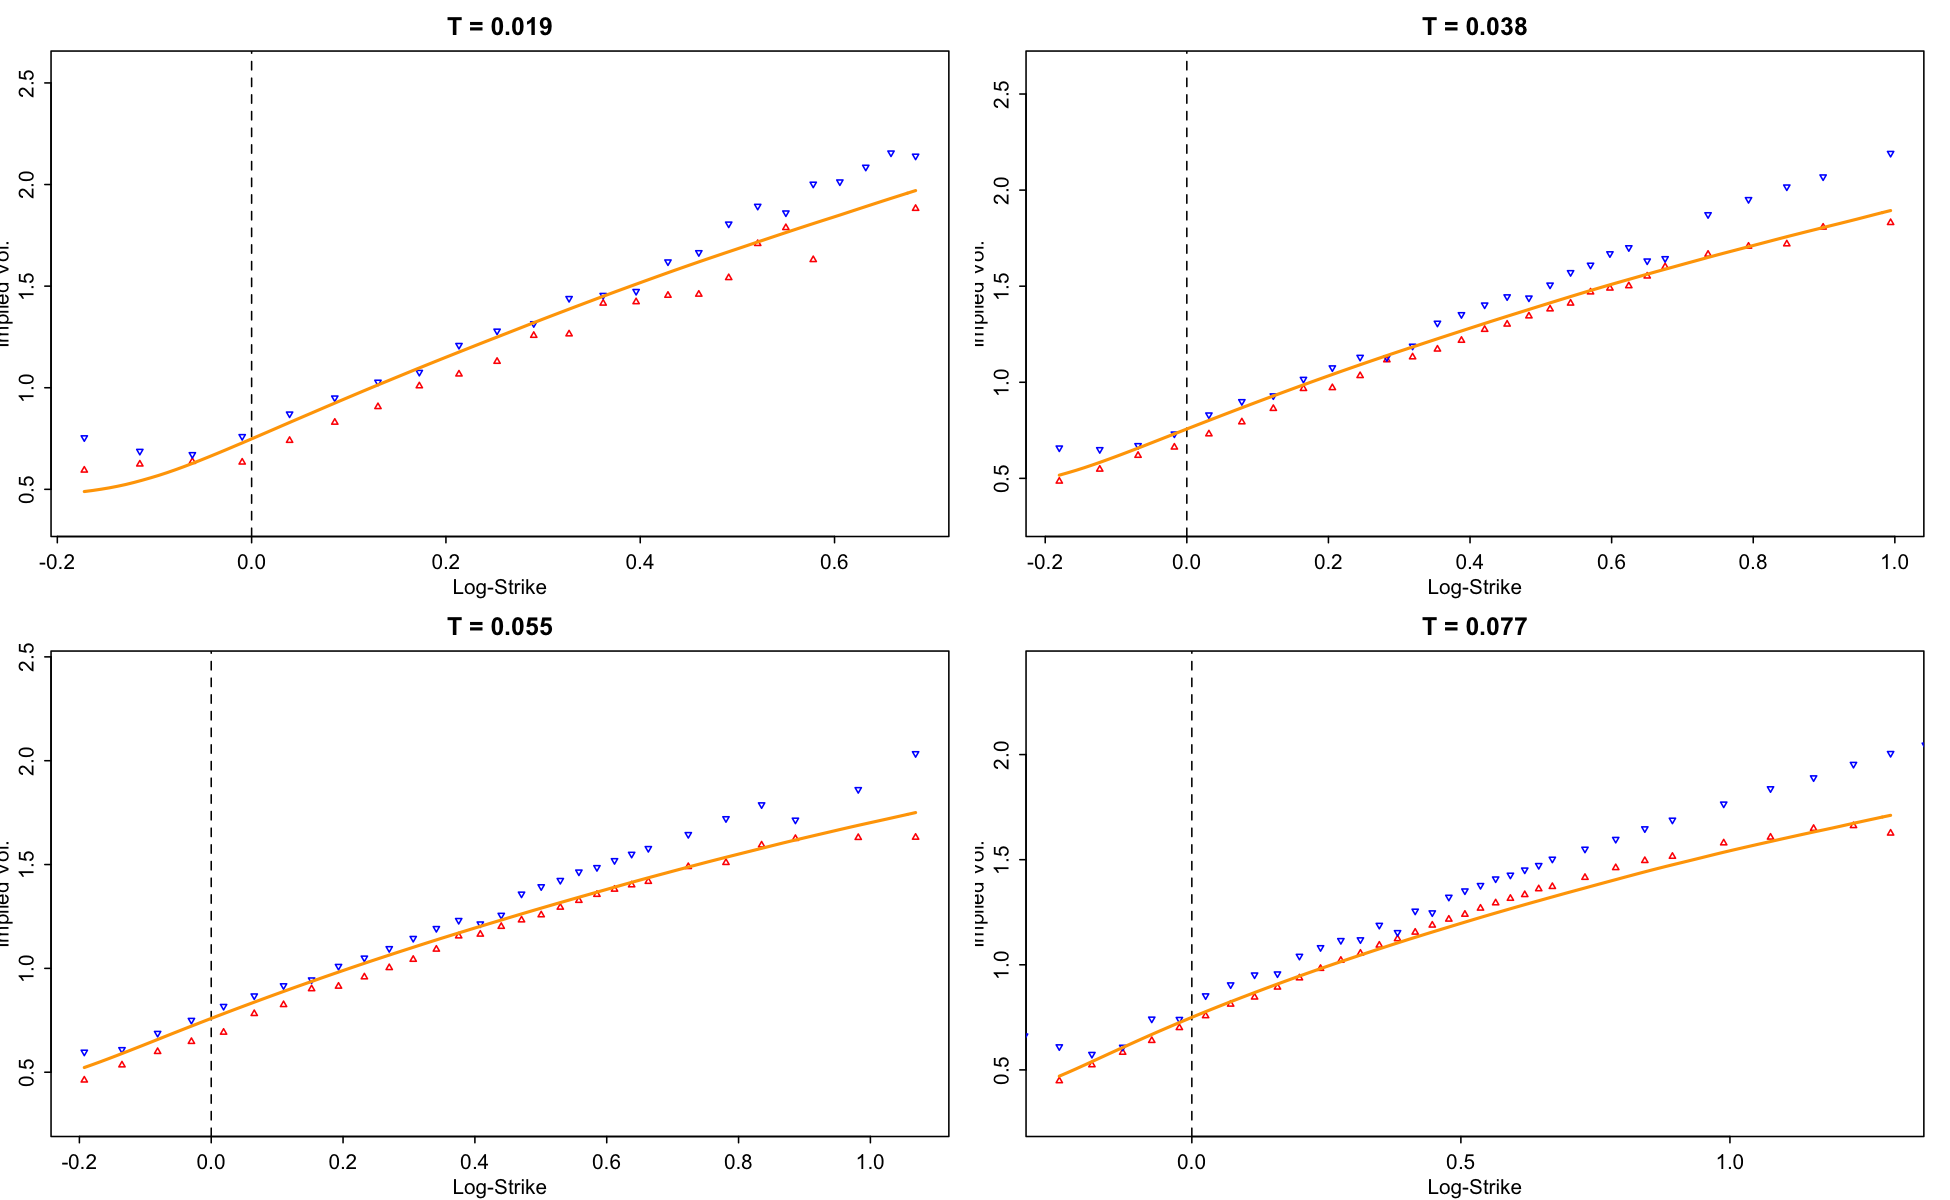

In [29]:
plot.vix <- plotIvolsMC(vixVolDataExtract, colnum = 2, mcMatrix = qrh.vix)
